In [1]:
from collections import namedtuple, OrderedDict
import itertools
import os
import numpy as np
from typing import Tuple
from typing import List
from typing import Dict
import random
from itertools import product
import copy
import re
import random

from utils import one_hot
from utils import generate_possible_object_names
from utils import numpy_array_to_image

from vocabulary import *
from object_vocabulary import *
from world import *
from grammer import *
from simulator import *
from relation_graph import *

from networkx.algorithms import isomorphism
from networkx import DiGraph
from networkx import line_graph

from generate_ReaSCAN import *

### Vocabulary Module

In [2]:
# test out the vocabulary
intransitive_verbs = ["walk"]
transitive_verbs = ["push", "pull"]
adverbs = ["while zigzagging", "while spinning", "cautiously", "hesitantly"]
nouns = ["circle", "cylinder", "square", "box"]
color_adjectives = ["red", "blue", "green", "yellow"]
size_adjectives = ["big", "small"]
relative_pronouns = ["that is"]
relation_clauses = ["in the same row as", 
                    "in the same column as", 
                    "in the same color as", 
                    "in the same shape as", 
                    "in the same size as",
                    "inside of"]
vocabulary = Vocabulary.initialize(intransitive_verbs=intransitive_verbs,
                                   transitive_verbs=transitive_verbs, adverbs=adverbs, nouns=nouns,
                                   color_adjectives=color_adjectives,
                                   size_adjectives=size_adjectives, 
                                   relative_pronouns=relative_pronouns, 
                                   relation_clauses=relation_clauses)

In [3]:
# test out the object vocab
min_object_size = 1
max_object_size = 4
object_vocabulary = ObjectVocabulary(shapes=vocabulary.get_semantic_shapes(),
                                     colors=vocabulary.get_semantic_colors(),
                                     min_size=min_object_size, max_size=max_object_size)
# object_vocabulary.generate_objects()

### Situtation Module

In [4]:
# test out situation repr
TEST_SITUATION_1 = Situation(grid_size=15, agent_position=Position(row=7, column=2), agent_direction=INT_TO_DIR[0],
                             target_object=PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                            position=Position(row=10, column=4),
                                                            vector=np.array([1, 0, 1])),
                             placed_objects=[PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                              position=Position(row=10, column=4),
                                                              vector=np.array([1, 0, 1])),
                                             PositionedObject(object=Object(size=4, color='green', shape='circle'),
                                                              position=Position(row=3, column=12),
                                                              vector=np.array([0, 1, 0]))], carrying=None)
# TEST_SITUATION_1.to_representation()

In [5]:
# test out our new object definition
PositionedObject(object=Object(size=4, color='green', shape='box'),
                 position=Position(row=3, column=12),
                 vector=np.array([0, 1, 0]), overflow=True, overlap=True)

PositionedObject(object=Object(size=4, color='green', shape='box'), position=Position(column=12, row=3), vector=array([0, 1, 0]), overflow=True, overlap=True)

### World Module with Mini-Gym

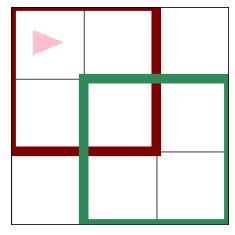

True

In [6]:
# test out the world
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
os.environ['QT_QPA_PLATFORM']='offscreen'

world = World(grid_size=3, colors=vocabulary.get_semantic_colors(),
              object_vocabulary=object_vocabulary,
              shapes=vocabulary.get_semantic_shapes(),
              save_directory="./tmp/")

world.place_object(Object(size=2, color="green", shape="box"), position=Position(row=1, column=1))
world.place_object(Object(size=2, color="red", shape="box"), position=Position(row=0, column=0))
_ = world.render_simple()
world.position_taken(position=Position(row=0, column=0), condition="box")


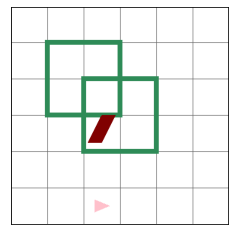

In [7]:
world = World(grid_size=6, colors=vocabulary.get_semantic_colors(),
              object_vocabulary=object_vocabulary,
              shapes=vocabulary.get_semantic_shapes(),
              save_directory="./tmp/")

# try to place an object on to the map
world.clear_situation()
# world.place_object(Object(size=4, color="green", shape="box"), position=Position(row=3, column=3))
world.place_object(Object(size=2, color="green", shape="box"), position=Position(row=2, column=2))
world.place_object(Object(size=2, color="green", shape="box"), position=Position(row=1, column=1))
world.place_object(Object(size=3, color="red", shape="cylinder"), position=Position(row=3, column=2))
world.place_agent_at(Position(row=5, column=2))

_ = world.render_simple()

verb = "push"
adverb = "cautiously"

# Direct walk.
action = "walk" # this is definit!
primitive_command = vocabulary.translate_word(action)
target_position = Position(row=3, column=2)
# simulator._world.get_current_situation().to_dict()["target_object"].position
world.go_to_position(position=target_position, manner=adverb, primitive_command=primitive_command)

# Object actions.
if True:
    semantic_action = vocabulary.translate_word(verb)
    world.move_object_to_wall(action=semantic_action, manner=adverb)
target_commands, target_demonstration = world.get_current_observations()

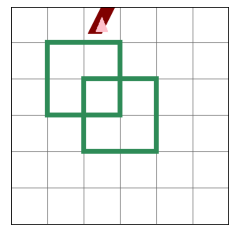

In [8]:
_ = world.render_simple()

### ReaSCAN Grammer Module

In [24]:
command_structs = []
grammer = Grammer(vocabulary)
for grammer_pattern in grammer._sample_grammer_pattern_reascan_train():
    print(grammer_pattern)
    relations = grammer.sample_object_relation_grammer(
    '$OBJ_0', 
    grammer.build_dependency_graph(grammer_pattern))
    for relation in relations:
        obj_pattern_map = relation[0]
        rel_map = relation[1]
        grammer_bindings = grammer.grounding_grammer_with_vocabulary(grammer_pattern, obj_pattern_map, rel_map)
        for obj_map in grammer_bindings:
            # here, we also sample the verb and adverb bindings!

            command_struct = {
                "obj_pattern_map" : obj_pattern_map,
                "rel_map" : rel_map,
                "obj_map" : obj_map,
                "grammer_pattern" : grammer_pattern,
                "adverb" : random.choice(vocabulary.get_adverbs()),
                "verb" : random.choice(vocabulary.get_transitive_verbs() + vocabulary.get_intransitive_verbs()),
            }
            command_structs += [command_struct]

$OBJ_0
$OBJ_0 ^ $OBJ_1
$OBJ_0 ^ $OBJ_1 & $OBJ_2


In [31]:
def get_command_struct_statistics(
    command_structs, run_name="ReaSCAN-Awesome", date="2021-05-06", 
    split="demo",
    compositional_split=False,
    n_sample=-1, n_runs=10,
    output_dir="../../data-files/ReaSCAN-compositional_splits/",
    save_to_disk=True,
    wandb=None
):
    statistics = OrderedDict({
        "run_name": run_name,
        "date": date,
        "splits": split,
        "number_of_these_examples_seen_in_training": -1 if not compositional_split else 0,
        "number_of_command_structs": len(command_structs),
    })
    if n_sample == -1:
        n_sample = len(command_structs)
    # If we are downsampling, we need to do more runs as well!
    random.shuffle(command_structs)
    
    patterns = set([])
    for command_s in command_structs:
        patterns.add(command_s["grammer_pattern"])
    statistics["command_patterns"] = list(patterns)
    
    pattern_stats = get_keyword_statistics(command_structs, include_keyword="grammer_pattern")
    statistics["pattern_stats"] = pattern_stats
    
    # verb
    verb_stats = get_keyword_statistics(command_structs, include_keyword="verb")
    statistics["verb_stats"] = verb_stats
    plot_dictionary(
        [verb_stats],
        title="Verbs",
        save_file=os.path.join(output_dir, f"verb_stats-{split}.png"),
        wandb=wandb,
    )
    
    # adverb
    adverb_stats = get_keyword_statistics(command_structs, include_keyword="adverb")
    # special handling for adverb for better readabilities
    adverb_stats_rebuild = {}
    for k, v in adverb_stats.items():
        if k == "":
            adverb_stats_rebuild["EMPTY"] = v
        else:
            adverb_stats_rebuild[k] = v
    statistics["adverb_stats"] = adverb_stats_rebuild
    plot_dictionary(
        [adverb_stats_rebuild],
        title="Adverbs",
        save_file=os.path.join(output_dir, f"adverb_stats-{split}.png"),
        wandb=wandb,
    )
    
    # relation
    relation_stats = get_relation_statistics(command_structs)
    if len(relation_stats) != 0:
        statistics["relation_stats"] = relation_stats
        plot_dictionary(
            [flatten_dictionary(relation_stats)],
            title="Relation-Types",
            save_file=os.path.join(output_dir, f"relation_type_stats-{split}.png"),
            wandb=wandb,
        )
    
    # attribute
    nouns = ["circle", "cylinder", "square", "box", "object"]
    n_stats = get_attribute_statistics(command_structs, include_keywords=nouns)
    statistics["shape_stats"] = n_stats
    plot_dictionary(
        [flatten_dictionary(n_stats)],
        title="Shapes",
        save_file=os.path.join(output_dir, f"shape_stats-{split}.png"),
        wandb=wandb,
    )
    
    color_adjectives = ["red", "blue", "green", "yellow"]
    c_stats = get_attribute_statistics(command_structs, include_keywords=color_adjectives)
    statistics["color_stats"] = c_stats
    plot_dictionary(
        [flatten_dictionary(c_stats)],
        title="Colors",
        save_file=os.path.join(output_dir, f"color_stats-{split}.png"),
        wandb=wandb,
    )

    size_adjectives = ["big", "small"]
    s_stats = get_attribute_statistics(command_structs, include_keywords=size_adjectives)
    statistics["size_stats"] = s_stats
    plot_dictionary(
        [flatten_dictionary(s_stats)],
        title="Sizes",
        save_file=os.path.join(output_dir, f"size_stats-{split}.png"),
        wandb=wandb,
    )
    
    # second order attribute
    color_adjectives = ["red", "blue", "green", "yellow"]
    nouns = ["circle", "cylinder", "square", "box", "object"]
    c_n_p = product(color_adjectives, nouns)
    include_keywords = [" ".join(c_n) for c_n in c_n_p]
    c_n_stats = get_attribute_statistics(command_structs, include_keywords=include_keywords)
    statistics["color_and_shape_stats"] = c_n_stats
    plot_dictionary(
        [flatten_dictionary(c_n_stats)],
        title="Colors-Shapes",
        save_file=os.path.join(output_dir, f"color+shape_stats-{split}.png"),
        wandb=wandb,
    )

    size_adjectives = ["big", "small"]
    nouns = ["circle", "cylinder", "square", "box", "object"]
    s_n_p = product(size_adjectives, nouns)
    include_keywords = [" ".join(s_n) for s_n in s_n_p]
    s_n_stats = get_attribute_statistics(command_structs, include_keywords=include_keywords)
    statistics["size_and_shape_stats"] = s_n_stats
    plot_dictionary(
        [flatten_dictionary(s_n_stats)],
        title="Sizes-Shapes",
        save_file=os.path.join(output_dir, f"size+shape_stats-{split}.png"),
        wandb=wandb,
    )
    
    # third order attribute
    size_adjectives = ["big", "small"]
    color_adjectives = ["red", "blue", "green", "yellow"]
    nouns = ["circle", "cylinder", "square", "box", "object"]
    all_p = product(size_adjectives, color_adjectives, nouns)
    include_keywords = [" ".join(a) for a in all_p]
    all_stats = get_attribute_statistics(command_structs, include_keywords=include_keywords)
    statistics["size_and_color_and_shape_stats"] = all_stats
    
    if save_to_disk:
        import yaml
        with open(os.path.join(output_dir, f"command_struct_only_stats-{split}.yml"), 'w') as yaml_file:
            yaml.dump(statistics, yaml_file, default_flow_style=False)
    
    return statistics

In [32]:
get_command_struct_statistics(
    command_structs, run_name="ReaSCAN-Awesome", date="2021-05-16", 
    split="demo",
    compositional_split=False,
    n_sample=-1, n_runs=10,
    output_dir="../../data-files/ReaSCAN-demo/",
    save_to_disk=True,
    wandb=None
)

OrderedDict([('run_name', 'ReaSCAN-Awesome'),
             ('date', '2021-05-16'),
             ('splits', 'demo'),
             ('number_of_these_examples_seen_in_training', -1),
             ('number_of_command_structs', 307643),
             ('command_patterns',
              ['$OBJ_0 ^ $OBJ_1 & $OBJ_2', '$OBJ_0 ^ $OBJ_1', '$OBJ_0']),
             ('pattern_stats',
              {'$OBJ_0 ^ $OBJ_1 & $OBJ_2': 302548,
               '$OBJ_0 ^ $OBJ_1': 5050,
               '$OBJ_0': 45}),
             ('verb_stats', {'pull': 102575, 'walk': 102520, 'push': 102548}),
             ('adverb_stats',
              {'hesitantly': 77114,
               'while zigzagging': 76894,
               'cautiously': 76778,
               'while spinning': 76857}),
             ('relation_stats',
              {'position-0': {'$IS_INSIDE': 59780,
                '$SAME_ROW': 103842,
                '$SAME_COLUMN': 103842,
                '$SAME_SHAPE': 20436,
                '$SAME_SIZE': 15060,
       

### ReaSCAN Simulator

In [13]:
simulator = Simulator(
    object_vocabulary, vocabulary, 
    grid_size=6, 
    n_object_max=10,
)

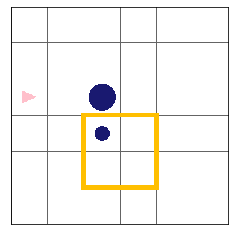

In [14]:
obj_pattern_map = {'$OBJ_0': '$ABS_SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'}
rel_map = {('$OBJ_0', '$OBJ_1'): '$SAME_SHAPE', ('$OBJ_0', '$OBJ_2'): '$IS_INSIDE'}
obj_map = {'$OBJ_0': 'object', '$OBJ_1': 'circle', '$OBJ_2': 'box'}
grammer_pattern = '$OBJ_0 ^ $OBJ_1 & $OBJ_2'
verb = "push"
adverb = "slowly"
sampled_world = simulator.sample_situations_from_grounded_grammer(
    copy.deepcopy(grammer_pattern), 
    copy.deepcopy(obj_pattern_map), 
    copy.deepcopy(rel_map), 
    copy.deepcopy(obj_map),
    is_plot=True,
    include_relation_distractor=False, 
    include_attribute_distractor=False, 
    include_isomorphism_distractor=False, 
    include_random_distractor=False,
    full_relation_probability=0.5,
    debug=False
)

In [15]:
is_transitive = False
if verb in simulator.vocabulary.get_transitive_verbs():
    is_transitive = True

# Direct walk.
action = "walk" # this is definit!
primitive_command = simulator.vocabulary.translate_word(action)
target_position = sampled_world["situation"].target_object.position

simulator._world.go_to_position(position=target_position, manner=adverb, primitive_command=primitive_command)

# Object actions.
if is_transitive:
    semantic_action = simulator.vocabulary.translate_word(verb)
    simulator._world.move_object_to_wall(action=semantic_action, manner=adverb)
target_commands, target_demonstration = simulator._world.get_current_observations()

In [16]:
target_commands

['walk', 'walk', 'turn right', 'walk', 'push', 'push']

### End-to-end Task Generation

In [ ]:
# Simulator robustness tests.
random.shuffle(command_structs)
simulator = Simulator(
    object_vocabulary, vocabulary, 
    grid_size=6, 
    n_object_max=10,
)
count = 0
special_count = 0
minor_count = 0
for test_struct in command_structs[:10000]:
    count += 1
    if count%1000==0:
        print(f"passing rate = {count}/{10000}")
    obj_pattern_map = test_struct["obj_pattern_map"]
    rel_map = test_struct["rel_map"]
    obj_map = test_struct["obj_map"]
    grammer_pattern = test_struct["grammer_pattern"]
    verb = test_struct["verb"]
    adverb = test_struct["adverb"]

    test_unique_find = 0
    for i in range(20):
        minor_count += 1
        sampled_world = simulator.sample_situations_from_grounded_grammer(
            copy.deepcopy(grammer_pattern), 
            copy.deepcopy(obj_pattern_map), 
            copy.deepcopy(rel_map), 
            copy.deepcopy(obj_map),
            is_plot=False,
            include_relation_distractor=True, 
            include_attribute_distractor=True, 
            include_isomorphism_distractor=False, 
            include_random_distractor=True,
            full_relation_probability=0.5, # 0.5 seems to work as well!
            debug=False
        )
#         if len(sampled_world["distractor_switch_map"]['relation']) == 2 and \
#             sampled_world["distractor_switch_map"]['relation'][0] == True and \
#             sampled_world["distractor_switch_map"]['relation'][0] == True:
#             special_count += 1
#             print(f"{special_count}/{minor_count}")
        assert len(sampled_world['obj_map']) == len(simulator._world.get_current_situation().to_representation()["placed_objects"])


1 / 2 unique solution find!


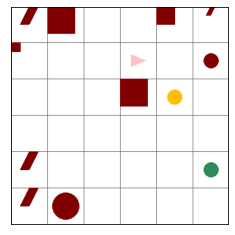

2 / 7 unique solution find!


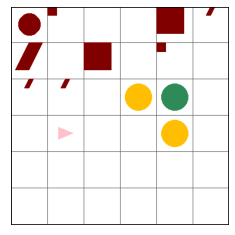

3 / 13 unique solution find!


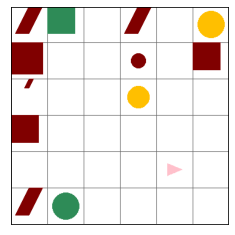

4 / 18 unique solution find!


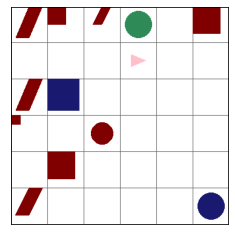

5 / 22 unique solution find!


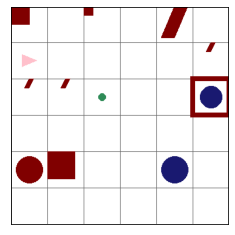

6 / 23 unique solution find!


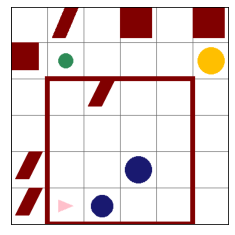

7 / 30 unique solution find!


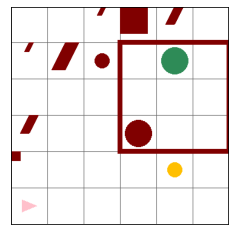

8 / 42 unique solution find!


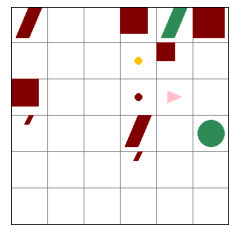

9 / 44 unique solution find!


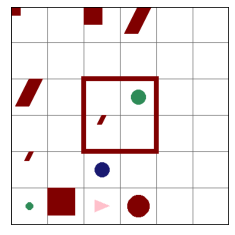

10 / 47 unique solution find!


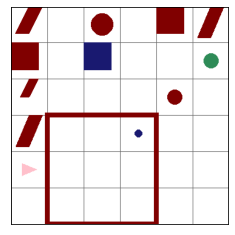

11 / 57 unique solution find!


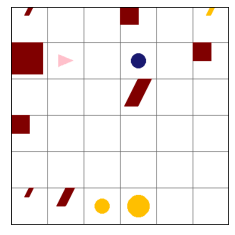

12 / 61 unique solution find!


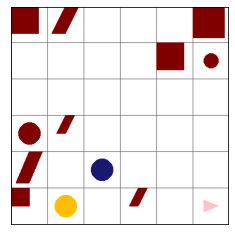

13 / 65 unique solution find!


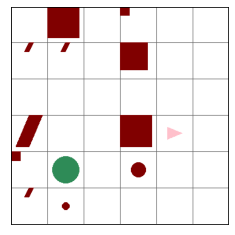

14 / 93 unique solution find!


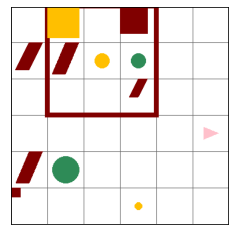

In [82]:
test_struct = {'obj_pattern_map': {'$OBJ_0': '$SHAPE',
  '$OBJ_1': '$COLOR $SHAPE',
  '$OBJ_2': '$COLOR $SHAPE'},
 'rel_map': OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
              (('$OBJ_0', '$OBJ_2'), '$SAME_COLUMN')]),
 'obj_map': {'$OBJ_0': 'circle',
  '$OBJ_1': 'red cylinder',
  '$OBJ_2': 'red square'},
 'grammer_pattern': '$OBJ_0 ^ $OBJ_1 & $OBJ_2',
 'adverb': 'while spinning',
 'verb': 'pull'}

simulator = Simulator(
    object_vocabulary, vocabulary, 
    grid_size=6, 
    n_object_max=10,
)

obj_pattern_map = test_struct["obj_pattern_map"]
rel_map = test_struct["rel_map"]
obj_map = test_struct["obj_map"]
grammer_pattern = test_struct["grammer_pattern"]
verb = test_struct["verb"]
adverb = test_struct["adverb"]

test_unique_find = 0
for i in range(100):
    sampled_world = simulator.sample_situations_from_grounded_grammer(
            copy.deepcopy(grammer_pattern), 
            copy.deepcopy(obj_pattern_map), 
            copy.deepcopy(rel_map), 
            copy.deepcopy(obj_map),
            is_plot=False,
            include_relation_distractor=True, 
            include_attribute_distractor=True, 
            include_isomorphism_distractor=True, 
            include_random_distractor=True,
            full_relation_probability=0.5, # 0.5 seems to work as well!
            debug=False
        )
    
    assert len(sampled_world['obj_map']) == len(simulator._world.get_current_situation().to_representation()["placed_objects"])
    
    graph = ReaSCANGraph(
        objects=sampled_world["obj_map"], 
        object_patterns=sampled_world["obj_pattern_map"], 
        vocabulary=vocabulary,
        positions=sampled_world["pos_map"], 
        referred_object=sampled_world["referred_obj"],
        debug=False
    )

    # graph.draw()
    
    pattern_graph = ReaSCANGraph(
        objects=obj_map, 
        object_patterns=None,
        vocabulary=vocabulary,
        relations=rel_map, 
        referred_object='$OBJ_0', 
        debug=False
    )
    
    # pattern_graph.draw()
    
    potential_referent_target = graph.find_referred_object_super_fast(
        pattern_graph, referred_object='$OBJ_0', 
        debug=False
    )
    
    if len(potential_referent_target) == 1:
        test_unique_find += 1
        print(f"{test_unique_find} / {i+1} unique solution find!")
        
        _ = simulator._world.render_simple()
        
        obj_determiner_map = graph.find_determiners(
            pattern_graph, 
            referred_object='$OBJ_0', 
            debug=False,
        )
        
        command_str = grammer.repre_str_command(
            grammer_pattern, rel_map, obj_map, 
            obj_determiner_map, 
            verb,
            adverb,
        )
        
        # Get the target command
        is_transitive = False
        if verb in simulator.vocabulary.get_transitive_verbs():
            is_transitive = True
        
        # Direct walk.
        action = "walk" # this is definit!
        primitive_command = simulator.vocabulary.translate_word(action)
        target_position = sampled_world["situation"].target_object.position

        simulator._world.go_to_position(
            position=target_position, manner=adverb, 
            primitive_command=primitive_command
        )

        # Object actions.
        if is_transitive:
            semantic_action = simulator.vocabulary.translate_word(verb)
            simulator._world.move_object_to_wall(action=semantic_action, manner=adverb)
        target_commands, _ = simulator._world.get_current_observations()
        
        task_struct = OrderedDict({
            "command": ",".join(command_str.split(" ")),
            "meaning": ",".join(command_str.split(" ")),
            "derivation": grammer_pattern,
            "situation": sampled_world["situation"].to_representation(),
            "target_commands": ",".join(target_commands),
            "verb_in_command": verb,
            "adverb_in_command": adverb,
            "referred_target": obj_map["$OBJ_0"],
            "object_pattern_map": obj_pattern_map,
            "relation_map": rel_map,
            "object_expression": obj_map,
            "n_object": len(sampled_world["obj_map"]),
            "n_distractor": len(sampled_world["obj_map"])-len(obj_map),
            "full_relation_distractor": True if len(sampled_world["distractor_switch_map"]["relation"]) == len(rel_map) else False,
            "has_relation_distractor": True if len(sampled_world["distractor_switch_map"]["relation"]) > 0 else False,
            "has_attribute_distractor": sampled_world["distractor_switch_map"]["attribute"],
            "has_isomorphism_distractor": sampled_world["distractor_switch_map"]["isomorphism"],
            "has_random_distractor": True if sampled_world["n_random_distractor"] != -1 else False,
            "n_random_distractor": sampled_world["n_random_distractor"] if sampled_world["n_random_distractor"] != -1 else 0,
            "relation_distractor_metadata": sampled_world["relation_distractor_metadata"],
            "attribute_distractor_metadata": sampled_world["attribute_distractor_metadata"],
            "isomorphism_distractor_metadata": sampled_world["isomorphism_distractor_metadata"],
            "random_distractor_metadata": sampled_world["random_distractor_metadata"],
        })
